# *ADD: match model and obs

- for one model

In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'monospace',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

Text(0.5, 0.98, 'colours assigned')

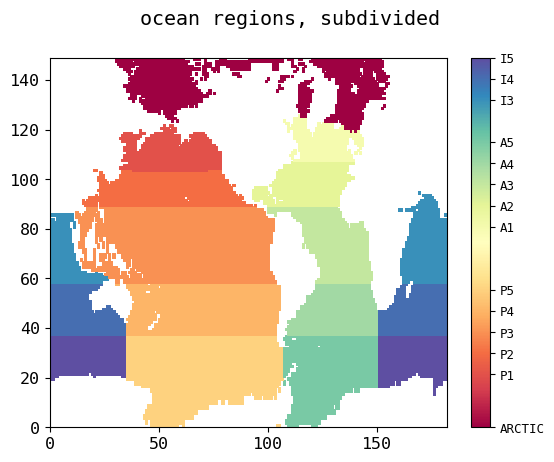

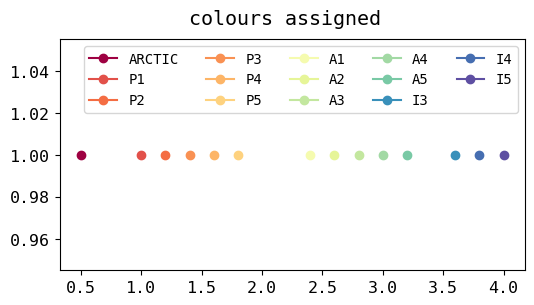

In [2]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan


w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('colours assigned')

In [3]:
mean_masks = np.zeros([len(regs), 149, 182])
for i, reg in enumerate(regs):
    mean_masks[i][maskno == regdict[reg]['number']] = 1

(1) obs data

In [4]:
yrst = 1990
yrend = 2020 

In [5]:
df = pd.read_csv('/gpfs/home/mep22dku/scratch/SOZONE/evalOutput/datasets/GLODAPv2.2022_GLOBAL_valid_DICTA_umolL_STITCHED.csv')

df = df[(df.YR >= yrst) & (df.YR <= yrend)]
df = df[df.PRES <= 10]  #surface

df

,Unnamed: 0,YR,MONTH,DIC,ALK,SAL,TEMP,PRES,LAT,LON,Y,X,Z,Zdep,DP,REG,STATION,CRUISE
18739,18739,1990.0,5.0,2104.092014,2400.979613,35.3910,12.0020,10.000,55.61800,-19.97000,114.0,131.0,4.999938,0.0,20149.0,2.4,69.0,669.0
18759,18759,1990.0,5.0,2111.699054,2409.879257,35.4320,12.9060,10.000,52.52800,-20.00000,111.0,131.0,4.999938,0.0,19376.0,2.4,66.0,669.0
18772,18772,1990.0,5.0,2101.615389,2416.452218,35.7550,15.3070,10.000,47.05700,-19.90000,107.0,131.0,4.999938,0.0,18427.0,2.4,51.0,669.0
18776,18776,1990.0,5.0,2140.324492,2429.130210,35.9650,15.3510,10.000,38.99800,-20.00300,102.0,131.0,4.999938,0.0,15513.0,2.6,41.0,669.0
18798,18798,1990.0,5.0,2115.226922,2423.152049,35.9030,14.7890,10.000,41.00300,-19.99800,103.0,131.0,4.999938,0.0,16507.0,2.6,43.0,669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388940,388940,2020.0,7.0,2075.801888,2313.458578,33.6795,8.6635,3.246,55.25276,-53.99350,114.0,115.0,4.999938,0.0,20008.0,2.4,66.0,4005.0
388943,388943,2020.0,7.0,2065.402333,2255.366830,32.2141,2.7871,9.934,54.95612,-54.28842,114.0,115.0,4.999938,0.0,19917.0,2.4,57.0,4005.0
388951,388951,2020.0,7.0,2030.767627,2250.484647,32.3338,7.3996,2.772,55.09360,-54.11322,114.0,115.0,4.999938,0.0,19976.0,2.4,61.0,4005.0
388952,388952,2020.0,7.0,2042.009887,2261.445162,32.5804,4.2822,9.503,55.09420,-54.11396,114.0,115.0,4.999938,0.0,19977.0,2.4,61.0,4005.0


In [6]:

tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])

tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tY = np.array(df['Y'])
tX = np.array(df['X'])

tREG_new = np.array(tX)


for j in range(len(tY)):
    y = tY[j].astype(int)
    x = tX[j].astype(int)
    tREG_new[j] = maskno[y, x]

print(tREG_new)
# len(tREG_new)

[2.4 2.4 2.4 ... 2.4 2.4 2.4]


In [7]:
# for model match
t0 = np.zeros_like(tDIC)

td = {}
td = {'YEAR': tYEAR,'MONTH': tMONTH, 'y': tY, 'x': tX ,'obs_DIC':  tDIC, 'obs_TA':tALK, 'REG': tREG_new, 
      'REG_Group': tREG_new}
tdat_OBS = pd.DataFrame(data=td)
tdat_OBS

,YEAR,MONTH,y,x,obs_DIC,obs_TA,REG,REG_Group
0,1990.0,5.0,114.0,131.0,2104.092014,2400.979613,2.4,2.4
1,1990.0,5.0,111.0,131.0,2111.699054,2409.879257,2.4,2.4
2,1990.0,5.0,107.0,131.0,2101.615389,2416.452218,2.4,2.4
3,1990.0,5.0,102.0,131.0,2140.324492,2429.130210,2.6,2.6
4,1990.0,5.0,103.0,131.0,2115.226922,2423.152049,2.6,2.6
...,...,...,...,...,...,...,...,...
19683,2020.0,7.0,114.0,115.0,2075.801888,2313.458578,2.4,2.4
19684,2020.0,7.0,114.0,115.0,2065.402333,2255.366830,2.4,2.4
19685,2020.0,7.0,114.0,115.0,2030.767627,2250.484647,2.4,2.4
19686,2020.0,7.0,114.0,115.0,2042.009887,2261.445162,2.4,2.4


(2) model data, one model, 2015-2020

In [8]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
depth = 0
dtype = 'ptrc'
modlist = ['TOM12_TJ_GEA0']

modnam = modlist[0]
tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
tdat_MOD = xr.open_mfdataset(tylist)

tdat_MOD_0 = tdat_MOD.isel(deptht= depth)
tdat_MOD_0

<xarray.Dataset>
Dimensions:               (y: 149, x: 182, time_counter: 372, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    deptht                float32 5.0
    time_centered         (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 2020-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/34)
    deptht_bounds         (time_counter, axis_nbounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    Alkalini              (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    O2                    (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    DIC                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    ...                    ...
    BSi                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    GON                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    C11                   (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    B14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    C14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
    D14B                  (time_counter, y, x) float32 dask.array<chunksize=(12, 149, 182), meta=np.ndarray>
Attributes:
    name:         ORCA2_1m_19900101_19901231
    description:  planktom sms variables
    title:        planktom sms variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2023-Jun-19 23:39:22 BST

In [9]:
# save DIC as Dataframe
tdat_MOD_DIC = tdat_MOD_0['DIC'].to_dataframe(dim_order=None)
tdat_MOD_DIC = tdat_MOD_DIC.loc[:, ['DIC']]     #only keep DIC and multiple index
tdat_MOD_DIC = tdat_MOD_DIC[(tdat_MOD_DIC[['DIC']] != 0).all(axis=1)]
tdat_MOD_DIC = tdat_MOD_DIC.dropna()

tdat_MOD_DIC = tdat_MOD_DIC.reset_index()

tdat_MOD_DIC['YEAR'] = tdat_MOD_DIC['time_counter'].apply(lambda x: x.year)
tdat_MOD_DIC['MONTH'] = tdat_MOD_DIC['time_counter'].apply(lambda x: x.month)

tdat_MOD_DIC


,time_counter,y,x,DIC,YEAR,MONTH
0,1990-01-16 12:00:00,1,50,0.002237,1990,1
1,1990-01-16 12:00:00,1,51,0.002230,1990,1
2,1990-01-16 12:00:00,1,52,0.002218,1990,1
3,1990-01-16 12:00:00,1,53,0.002202,1990,1
4,1990-01-16 12:00:00,1,54,0.002186,1990,1
...,...,...,...,...,...,...
6189331,2020-12-16 12:00:00,148,147,0.002138,2020,12
6189332,2020-12-16 12:00:00,148,148,0.002139,2020,12
6189333,2020-12-16 12:00:00,148,149,0.002154,2020,12
6189334,2020-12-16 12:00:00,148,150,0.002199,2020,12


In [10]:
# save TA as Dataframe
tdat_MOD_TA = tdat_MOD_0['Alkalini'].to_dataframe(dim_order=None)
tdat_MOD_TA = tdat_MOD_TA.loc[:, ['Alkalini']]     #only keep TA and multiple index
tdat_MOD_TA = tdat_MOD_TA[(tdat_MOD_TA[['Alkalini']] != 0).all(axis=1)]
tdat_MOD_TA = tdat_MOD_TA.dropna()

tdat_MOD_TA = tdat_MOD_TA.reset_index()

tdat_MOD_TA['YEAR'] = tdat_MOD_TA['time_counter'].apply(lambda x: x.year)
tdat_MOD_TA['MONTH'] = tdat_MOD_TA['time_counter'].apply(lambda x: x.month)

tdat_MOD_TA


,time_counter,y,x,Alkalini,YEAR,MONTH
0,1990-01-16 12:00:00,1,50,0.002373,1990,1
1,1990-01-16 12:00:00,1,51,0.002363,1990,1
2,1990-01-16 12:00:00,1,52,0.002349,1990,1
3,1990-01-16 12:00:00,1,53,0.002330,1990,1
4,1990-01-16 12:00:00,1,54,0.002310,1990,1
...,...,...,...,...,...,...
6189331,2020-12-16 12:00:00,148,147,0.002209,2020,12
6189332,2020-12-16 12:00:00,148,148,0.002207,2020,12
6189333,2020-12-16 12:00:00,148,149,0.002218,2020,12
6189334,2020-12-16 12:00:00,148,150,0.002257,2020,12


(3) match by YEAR, MONTH, Y, X

In [11]:
tdat_merge_modDIC = pd.merge(tdat_MOD_DIC, tdat_OBS, on=['YEAR', 'MONTH', 'y', 'x'])

tdat_merge_modDIC = tdat_merge_modDIC.loc[:, ['DIC','REG','REG_Group']]

tdat_merge_modDIC_mean = tdat_merge_modDIC.groupby(by=["REG_Group"]).mean()
tdat_merge_modDIC_mean

,DIC,REG
REG_Group,,
0.5,0.002110,0.5
1.0,0.002051,1.0
1.2,0.002032,1.2
1.4,0.002002,1.4
1.6,0.002096,1.6
1.8,0.002212,1.8
2.4,0.002088,2.4
2.6,0.002162,2.6
2.8,0.002080,2.8


In [12]:
tdat_merge_modTA = pd.merge(tdat_MOD_TA, tdat_OBS, on=['YEAR', 'MONTH', 'y', 'x'])

tdat_merge_modTA = tdat_merge_modTA.loc[:, ['Alkalini','REG','REG_Group']]

tdat_merge_modTA_mean = tdat_merge_modTA.groupby(by=["REG_Group"]).mean()
tdat_merge_modTA_mean

,Alkalini,REG
REG_Group,,
0.5,0.002254,0.5
1.0,0.002245,1.0
1.2,0.002373,1.2
1.4,0.002371,1.4
1.6,0.002424,1.6
1.8,0.002353,1.8
2.4,0.002291,2.4
2.6,0.002533,2.6
2.8,0.002471,2.8


# ??? (4) map to land or water

In [13]:

# mod_Y = tdat_MDL_0['mod_Y'].values
# mod_X = tdat_MDL_0['mod_X'].values

# water_at_level0 = np.zeros_like(mod_Y)
# for i in range(0,len(mod_Y)):
#     water_at_level0[i] = tmask[0,int(mod_Y[i]),int(mod_X[i])] #at level 0, do we map to land or water

# obs data

In [14]:
td = {}
td = {'DIC':  tDIC, 'TA':tALK, 'REG': tREG_new, 'REG_Group': tREG_new,}
tdat = pd.DataFrame(data=td)

tdat_fil = tdat[(tdat.DIC>-999) & (tdat.TA>-999) & (tdat.DIC != 0) & (tdat.TA != 0)]

tdat_fil_mean = tdat_fil.groupby(by=["REG_Group"]).mean()
tdat_fil_mean

,DIC,TA,REG
REG_Group,,,
0.5,2009.272792,2162.939725,0.5
1.0,2056.113143,2248.313408,1.0
1.2,2029.729962,2333.155341,1.2
1.4,1994.805573,2324.633457,1.4
1.6,2082.613908,2378.459521,1.6
1.8,2201.402031,2345.347694,1.8
2.4,2130.505763,2352.674924,2.4
2.6,2089.543237,2396.301380,2.6
2.8,2025.046600,2364.825541,2.8


# model data

In [15]:
data_mapping = {}

for modnam in modlist:
    tylist = make_yearlist(yrst, yrend, dtype, modnam, baseDir)
    tdat = xr.open_mfdataset(tylist)

    DIC0 = tdat.DIC.isel(deptht=depth)
    TA0 = tdat.Alkalini.isel(deptht=depth)
    DIC_t = DIC0.mean(dim = ['time_counter'])
    TA_t = TA0.mean(dim = ['time_counter'])

    DIC_total_mean = np.zeros([len(regs)])
    TA_total_mean = np.zeros([len(regs),])

    for j in range(len(regs)):
            mask_data_array = xr.DataArray(mean_masks[j], dims=['y', 'x'])
            DIC_total_mean[j] = DIC_t.weighted(mask_data_array).mean(dim = ['x','y'])
            TA_total_mean[j] = TA_t.weighted(mask_data_array).mean(dim = ['x','y'])

    data_mapping[modnam] = {'TA_total_mean':  TA_total_mean, 'DIC_total_mean':DIC_total_mean}

data_mapping = pd.DataFrame(data=data_mapping)
data_mapping

,TOM12_TJ_GEA0
DIC_total_mean,"[0.0018802899849814055, 0.002062171550508292, ..."
TA_total_mean,"[0.0019865848888474622, 0.002249527346290497, ..."


# === try plot ====

In [16]:
# marker = ['^','s','v','*','X']
marker = ['o','o','o','o','o']
color = ['r','m','c','y','g']
s = 70

Text(0.5, 1.0, '1990-2020 Surface DIC')

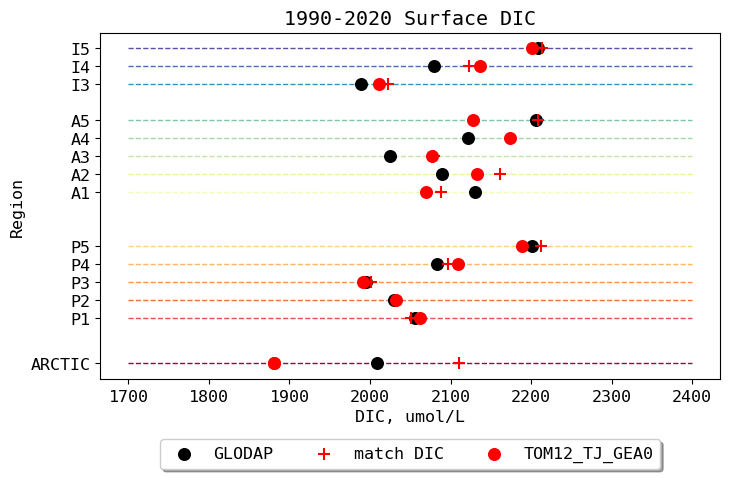

In [17]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)

#GLODAP
plt.scatter(tdat_fil_mean['DIC'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=4)

# match model data
plt.scatter(tdat_merge_modDIC_mean['DIC']* 1e6,tdat_merge_modDIC_mean['REG'],
            marker = '+', s=s,label = 'match DIC',color='r', zorder=5)

# model data
for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter(data_mapping[modam]['DIC_total_mean'][i] * 1e6, regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter(data_mapping[modam]['DIC_total_mean'][0] * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable

#background region line
xmin = 1700
xmax = 2400
y = (0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3, 3.2, 3.6, 3.8, 4)
labels = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-4)

    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-3)        # line legend
    regdict[regs[i]]['colour'] = rgba


# y label
plt.yticks(y, labels) #rotation='vertical')


# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis

# ax.set_facecolor("black")

# plt.title(f'{yrst}-{yrend} Surface TA vs. DIC, TOM12_TJ_GEA0')
plt.xlabel('DIC, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface DIC')


Text(0.5, 1.0, '1990-2020 Surface TA')

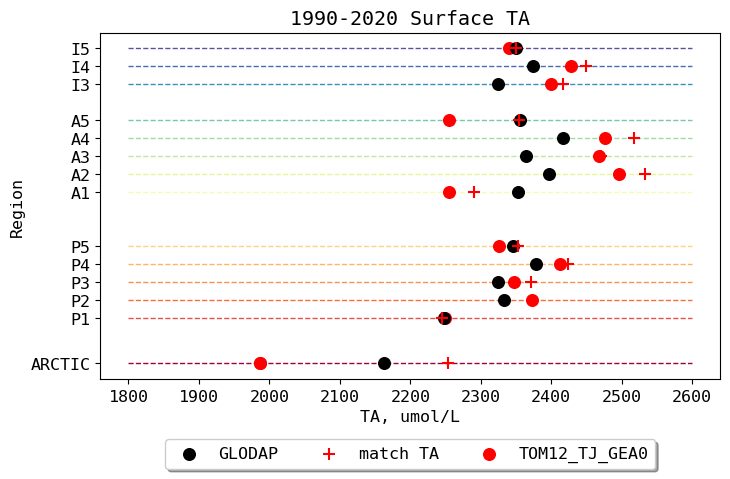

In [18]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


#GLODAP
plt.scatter(tdat_fil_mean['TA'],tdat_fil_mean['REG'] ,marker = 'o', s=s,label = 'GLODAP',color='k', zorder=5)

# match
plt.scatter(tdat_merge_modTA_mean['Alkalini']* 1e6,tdat_merge_modTA_mean['REG'] ,
            marker = '+', s=s,label = 'match TA',color='r', zorder=5)

#model
for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter(data_mapping[modam]['TA_total_mean'][i] * 1e6, regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter(data_mapping[modam]['TA_total_mean'][0] * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable

#background region line
xmin = 1800
xmax = 2600
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface TA')


Text(0.5, 1.0, '1990-2020 Surface TA-DIC')

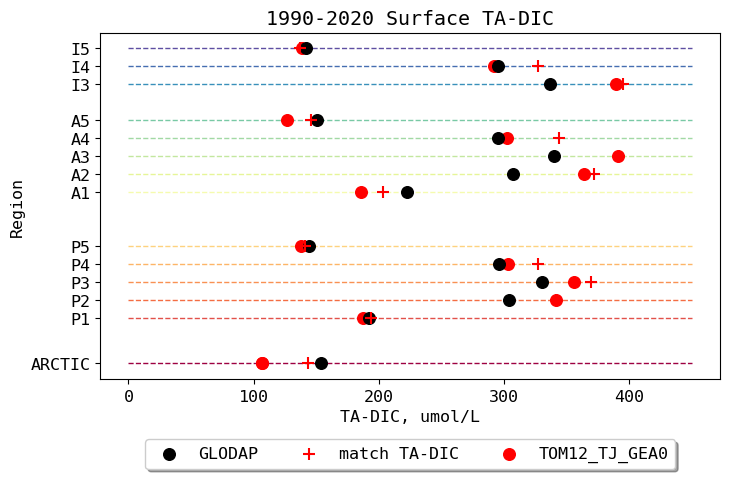

In [24]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)


#GLODAP
plt.scatter(tdat_fil_mean['TA'] - tdat_fil_mean['DIC'],
            tdat_fil_mean['REG'] ,marker = 'o',s=s, label = 'GLODAP',color='k', zorder=5)

# match
plt.scatter((tdat_merge_modTA_mean['Alkalini']-tdat_merge_modDIC_mean['DIC'])* 1e6,
            tdat_merge_modTA_mean['REG'] ,marker = '+', s=s,label = 'match TA-DIC',color='r', zorder=5)

#Model
for m, modam in enumerate(modlist):
    for i in range(0,len(regs)):
        plt.scatter((data_mapping[modam]['TA_total_mean'][i]-data_mapping[modam]['DIC_total_mean'][i]) * 1e6, 
                    regdict[regs[i]]['number'], 
                    marker = marker[m], color=color[m],s=s, zorder=4)
    
    plt.scatter((data_mapping[modam]['TA_total_mean'][0]-data_mapping[modam]['DIC_total_mean'][0]) * 1e6, regdict[regs[0]]['number'], 
            marker = marker[m], label = modam, color=color[m],s=s, zorder=4) # for lable


#background region line
xmin = 0
xmax = 450
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.hlines(y=regdict[regs[i]]['number'], 
               xmin=xmin, 
               xmax=xmax, 
                colors = rgba, linestyles='--', lw=1, zorder=-5)
    # plt.plot(xmin,regdict[regs[i]]['number'], 
    #          color = rgba, label = regs[i],zorder=-4)        # for legend
    regdict[regs[i]]['colour'] = rgba

# y label
plt.yticks(y, labels) #rotation='vertical')

# legend position
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3) # Put a legend below current axis


plt.xlabel('TA-DIC, umol/L')
plt.ylabel('Region')
plt.title(f'{yrst}-{yrend} Surface TA-DIC')
